# PyLPG Electricity Model Example
This notebook demonstrates how to use PyLPG electricity model to electricity loads for multiple buildings.

# Imports
Import required libraries and set visualization defaults.

In [1]:
import os

import pandas as pd
import matplotlib.pyplot as plt

from entise.core.generator import Generator
from entise.constants import Types


# Load Data
We load building parameters from objects.csv and simulation data from the data folder.

In [2]:
# Load data
cwd = "."  # notebook runs inside examples/electricity_demandlib

objects = pd.read_csv(os.path.join(cwd, "objects.csv"))

data = {}
common_data_folder = "../common_data"

for file in os.listdir(os.path.join(cwd, common_data_folder)):
    if file.endswith(".csv"):
        name = file.split(".")[0]
        data[name] = pd.read_csv(
            os.path.join(cwd, common_data_folder, file),
            parse_dates=True,
        )

print("Loaded data keys:", list(data.keys()))

Loaded data keys: ['validation_weather', 'weather']


We limit the generation to only the first building for faster generation and visualization. Feel free to expand it to more buildings by removing or changing this line.

In [3]:
objects = objects.iloc[:1]

# Instantiate and Configure Model
Initialize the time series generator and configure it with building objects.

In [4]:
gen = Generator()
gen.add_objects(objects)

summary, df = gen.generate(data, workers=1)

  0%|          | 0/1 [00:00<?, ?it/s]

Working in directory: C:\Users\ge23nur\Documents\Python Scripts\TS_Creator\.venv\Lib\site-packages\pylpg\C1
Creating
executing in C:\Users\ge23nur\Documents\Python Scripts\TS_Creator\.venv\Lib\site-packages\pylpg\C1
Reading json file C:\Users\ge23nur\Documents\Python Scripts\TS_Creator\.venv\Lib\site-packages\pylpg\C1\results\Results\Sum.Air Conditioning Load.House.json
Reading json file C:\Users\ge23nur\Documents\Python Scripts\TS_Creator\.venv\Lib\site-packages\pylpg\C1\results\Results\Sum.Apparent.HH1.json
Reading json file C:\Users\ge23nur\Documents\Python Scripts\TS_Creator\.venv\Lib\site-packages\pylpg\C1\results\Results\Sum.Apparent.House.json
Reading json file C:\Users\ge23nur\Documents\Python Scripts\TS_Creator\.venv\Lib\site-packages\pylpg\C1\results\Results\Sum.Cold Water.HH1.json
Reading json file C:\Users\ge23nur\Documents\Python Scripts\TS_Creator\.venv\Lib\site-packages\pylpg\C1\results\Results\Sum.Cold Water.House.json
Reading json file C:\Users\ge23nur\Documents\Python

100%|██████████| 1/1 [05:39<00:00, 339.77s/it]


# Results Summary
Below is a summary of the annual electricity demands (in kWh/a) and peak loads (W).

In [5]:
print("Summary:")
summary_kwh = (summary / 1000).round(0).astype(int)
summary_kwh.rename(columns=lambda x: x.replace("[W]", "[kW]").replace("[Wh]", "[kWh]"), inplace=True)
print(summary_kwh.to_string())

Summary:
   electricity:demand[kWh]  electricity:load_max[kW]
1                     3245                         3


# Preparation of Data

In [6]:
# Prepare data
building_id = objects["id"].iat[0]
res = df.get(building_id)

df = res[Types.ELECTRICITY]
df.index = pd.to_datetime(df.index, utc=True)

# Visualization of Results
Visualize weekly electricity loads for a selected building.

In [7]:
def plot_weekly_profile():
        # Pick the first full week starting Monday (or fallback: first 7 days)
        start = df.index.min().normalize()
        start = start + pd.Timedelta(days=(7 - start.weekday()) % 7)
        end = start + pd.Timedelta(days=7)

        s_week = df.loc[(df.index >= start) & (df.index < end)]

        fig, ax = plt.subplots(figsize=(15, 5))
        ax.plot(s_week.index, s_week.values, alpha=0.9)
        ax.set_title(f"Building ID: {building_id} - Electricity Load (Weekly)")
        ax.set_xlabel("Time")
        ax.set_ylabel("Electricity load (W)")
        ax.grid(True)
        plt.tight_layout()
        plt.show()

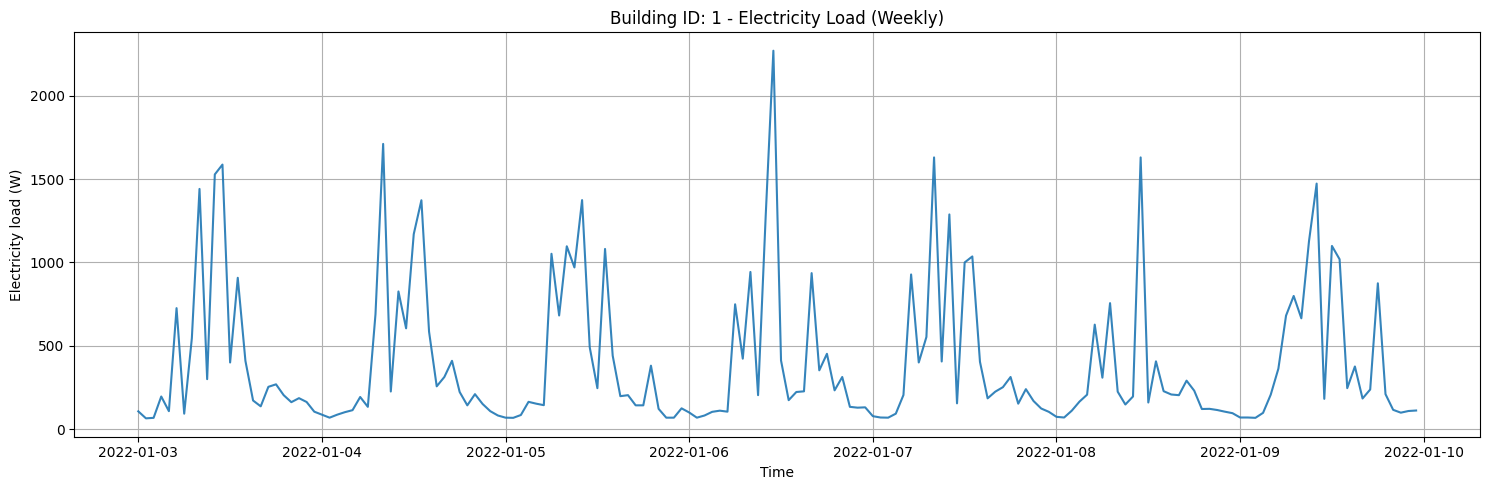

In [8]:
plot_weekly_profile()

# Seasonal Electricity Loads
Next, we visualize the electricity loads for different seasons

In [9]:
def plot_seasonal_subplots():
        df_tmp = df.copy()
        df_tmp.columns = ["load"]
        df_tmp["month"] = df_tmp.index.month
        df_tmp["hour"] = df_tmp.index.hour

        # Map month → season (no helper defs)
        df_tmp["season"] = "Autumn (SON)"
        df_tmp.loc[df_tmp["month"].isin([12, 1, 2]), "season"] = "Winter (DJF)"
        df_tmp.loc[df_tmp["month"].isin([3, 4, 5]), "season"] = "Spring (MAM)"
        df_tmp.loc[df_tmp["month"].isin([6, 7, 8]), "season"] = "Summer (JJA)"
        df_tmp.loc[df_tmp["month"].isin([9, 10, 11]), "season"] = "Autumn (SON)"

        prof = df_tmp.groupby(["season", "hour"])["load"].mean().reset_index()

        fig, axes = plt.subplots(2, 2, figsize=(14, 8), sharex=True, sharey=True)
        axes = axes.flatten()

        season_order = ["Winter (DJF)", "Spring (MAM)", "Summer (JJA)", "Autumn (SON)"]

        for i, season in enumerate(season_order):
            ax = axes[i]
            df_season = prof[prof["season"] == season]
            ax.plot(df_season["hour"], df_season["load"], alpha=0.9)
            ax.set_title(season)
            ax.grid(True)

        fig.suptitle(f"Building ID: {building_id} - Seasonal Average Daily Profiles", fontsize=14)
        fig.supxlabel("Hour of day")
        fig.supylabel("Electricity load (W)")
        plt.tight_layout()
        plt.show()

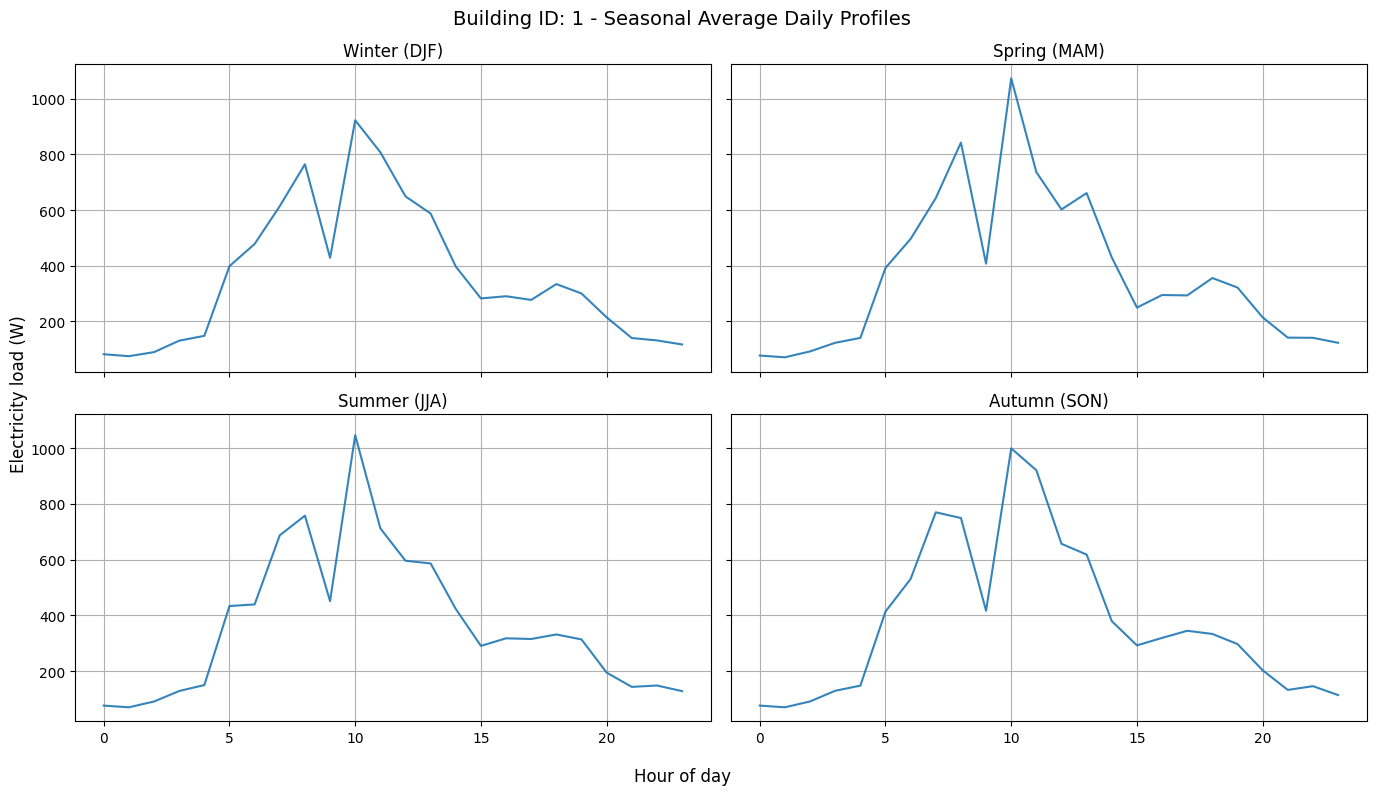

In [10]:
plot_seasonal_subplots()